In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import INFO, OrganAMNIST
from transformers import ViTForImageClassification
from transformers import AdamW

def load_data(data_flag='organamnist', batch_size=16):
    n_classes = len(INFO[data_flag]['label'])
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    train_dataset = OrganAMNIST(split='train', transform=transform, download=True)
    val_dataset = OrganAMNIST(split='val', transform=transform, download=True)
    test_dataset = OrganAMNIST(split='test', transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, n_classes

def setup_model(n_classes):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes)
    return model

def train_and_evaluate(model, train_loader, val_loader, device):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    best_model_path = 'best_model.pth'

    model.train()
    for epoch in range(10):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1).long()

                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Accuracy: {accuracy}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with accuracy: {accuracy}% at epoch {epoch+1}")

    print(f'Training complete. Best model was saved with an accuracy of {best_accuracy}%.')




def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, test_loader, n_classes = load_data()
    model = setup_model(n_classes)
    train_and_evaluate(model, train_loader, val_loader, device)

if __name__ == '__main__':
    main()

Using downloaded and verified file: C:\Users\metho\.medmnist\organamnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 93.77812781278128%
Confusion Matrix:
 [[ 973    0    0    0    7   43    4    0    0    9    0]
 [   7  688   44    0    4   35    1    0    0    5    0]
 [  30   11  729    0    1   19    1    0    0    2    0]
 [  14    0    0  731    2    0    2    1    0    0   35]
 [  96    2    8    0 1647  114    0    1    3   58  135]
 [  19    1    2    2   58 1861    2    0    6    4   10]
 [   0    0    0    0    0   30 3191    0   64    0    0]
 [   0    0    0    0    0    0    0 1746    0    0    0]
 [   0    0    0    0    0    1    3    0 1809    0    0]
 [  73    2    0    0   28   12   10    0    0 1478   18]
 [   5    0    1    2   24   10    0   19    0    6 1817]]
Shape of Confusion Matrix: (11, 11)


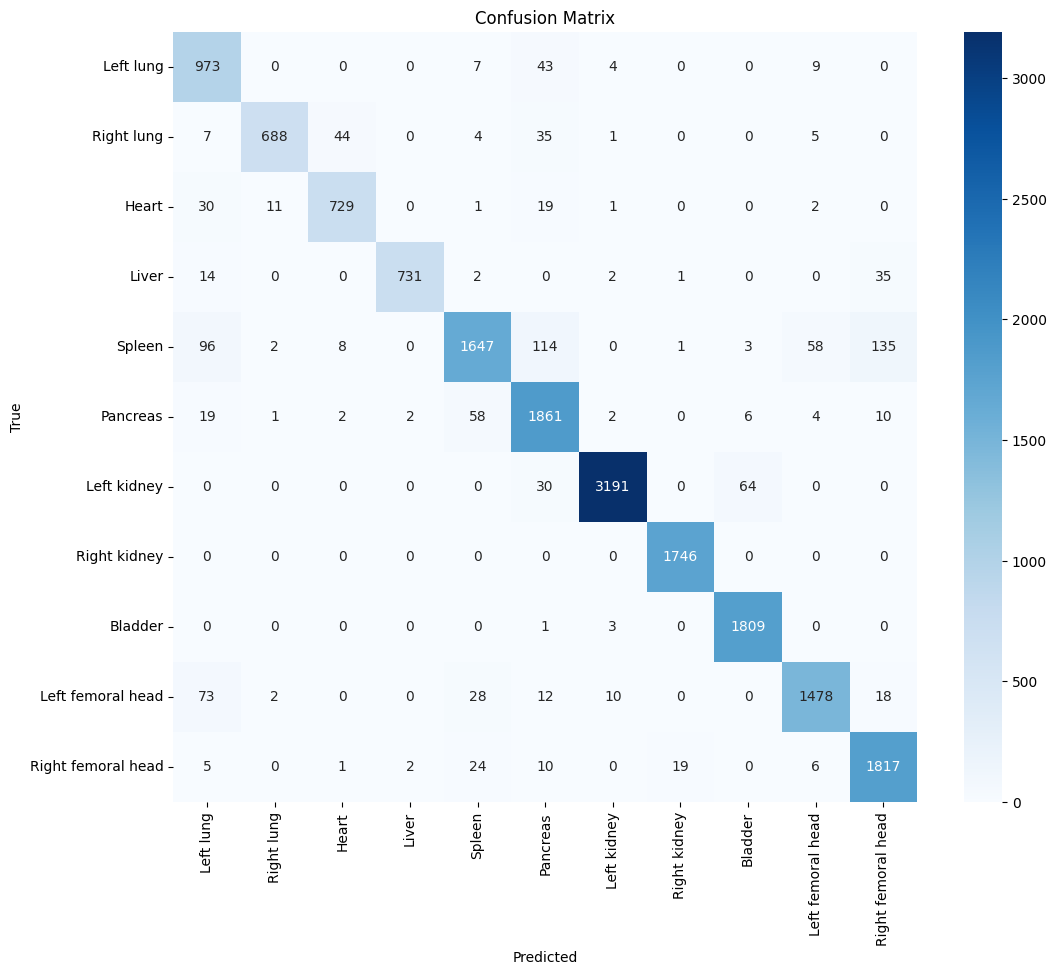


Classification Report:

                    precision    recall  f1-score   support

         Left lung     0.7995    0.9392    0.8637      1036
        Right lung     0.9773    0.8776    0.9247       784
             Heart     0.9298    0.9193    0.9245       793
             Liver     0.9946    0.9312    0.9618       785
            Spleen     0.9300    0.7980    0.8589      2064
          Pancreas     0.8758    0.9471    0.9100      1965
       Left kidney     0.9928    0.9714    0.9820      3285
      Right kidney     0.9881    1.0000    0.9940      1746
           Bladder     0.9612    0.9978    0.9792      1813
 Left femoral head     0.9462    0.9118    0.9287      1621
Right femoral head     0.9017    0.9644    0.9320      1884

          accuracy                         0.9378     17776
         macro avg     0.9361    0.9325    0.9327     17776
      weighted avg     0.9403    0.9378    0.9376     17776



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

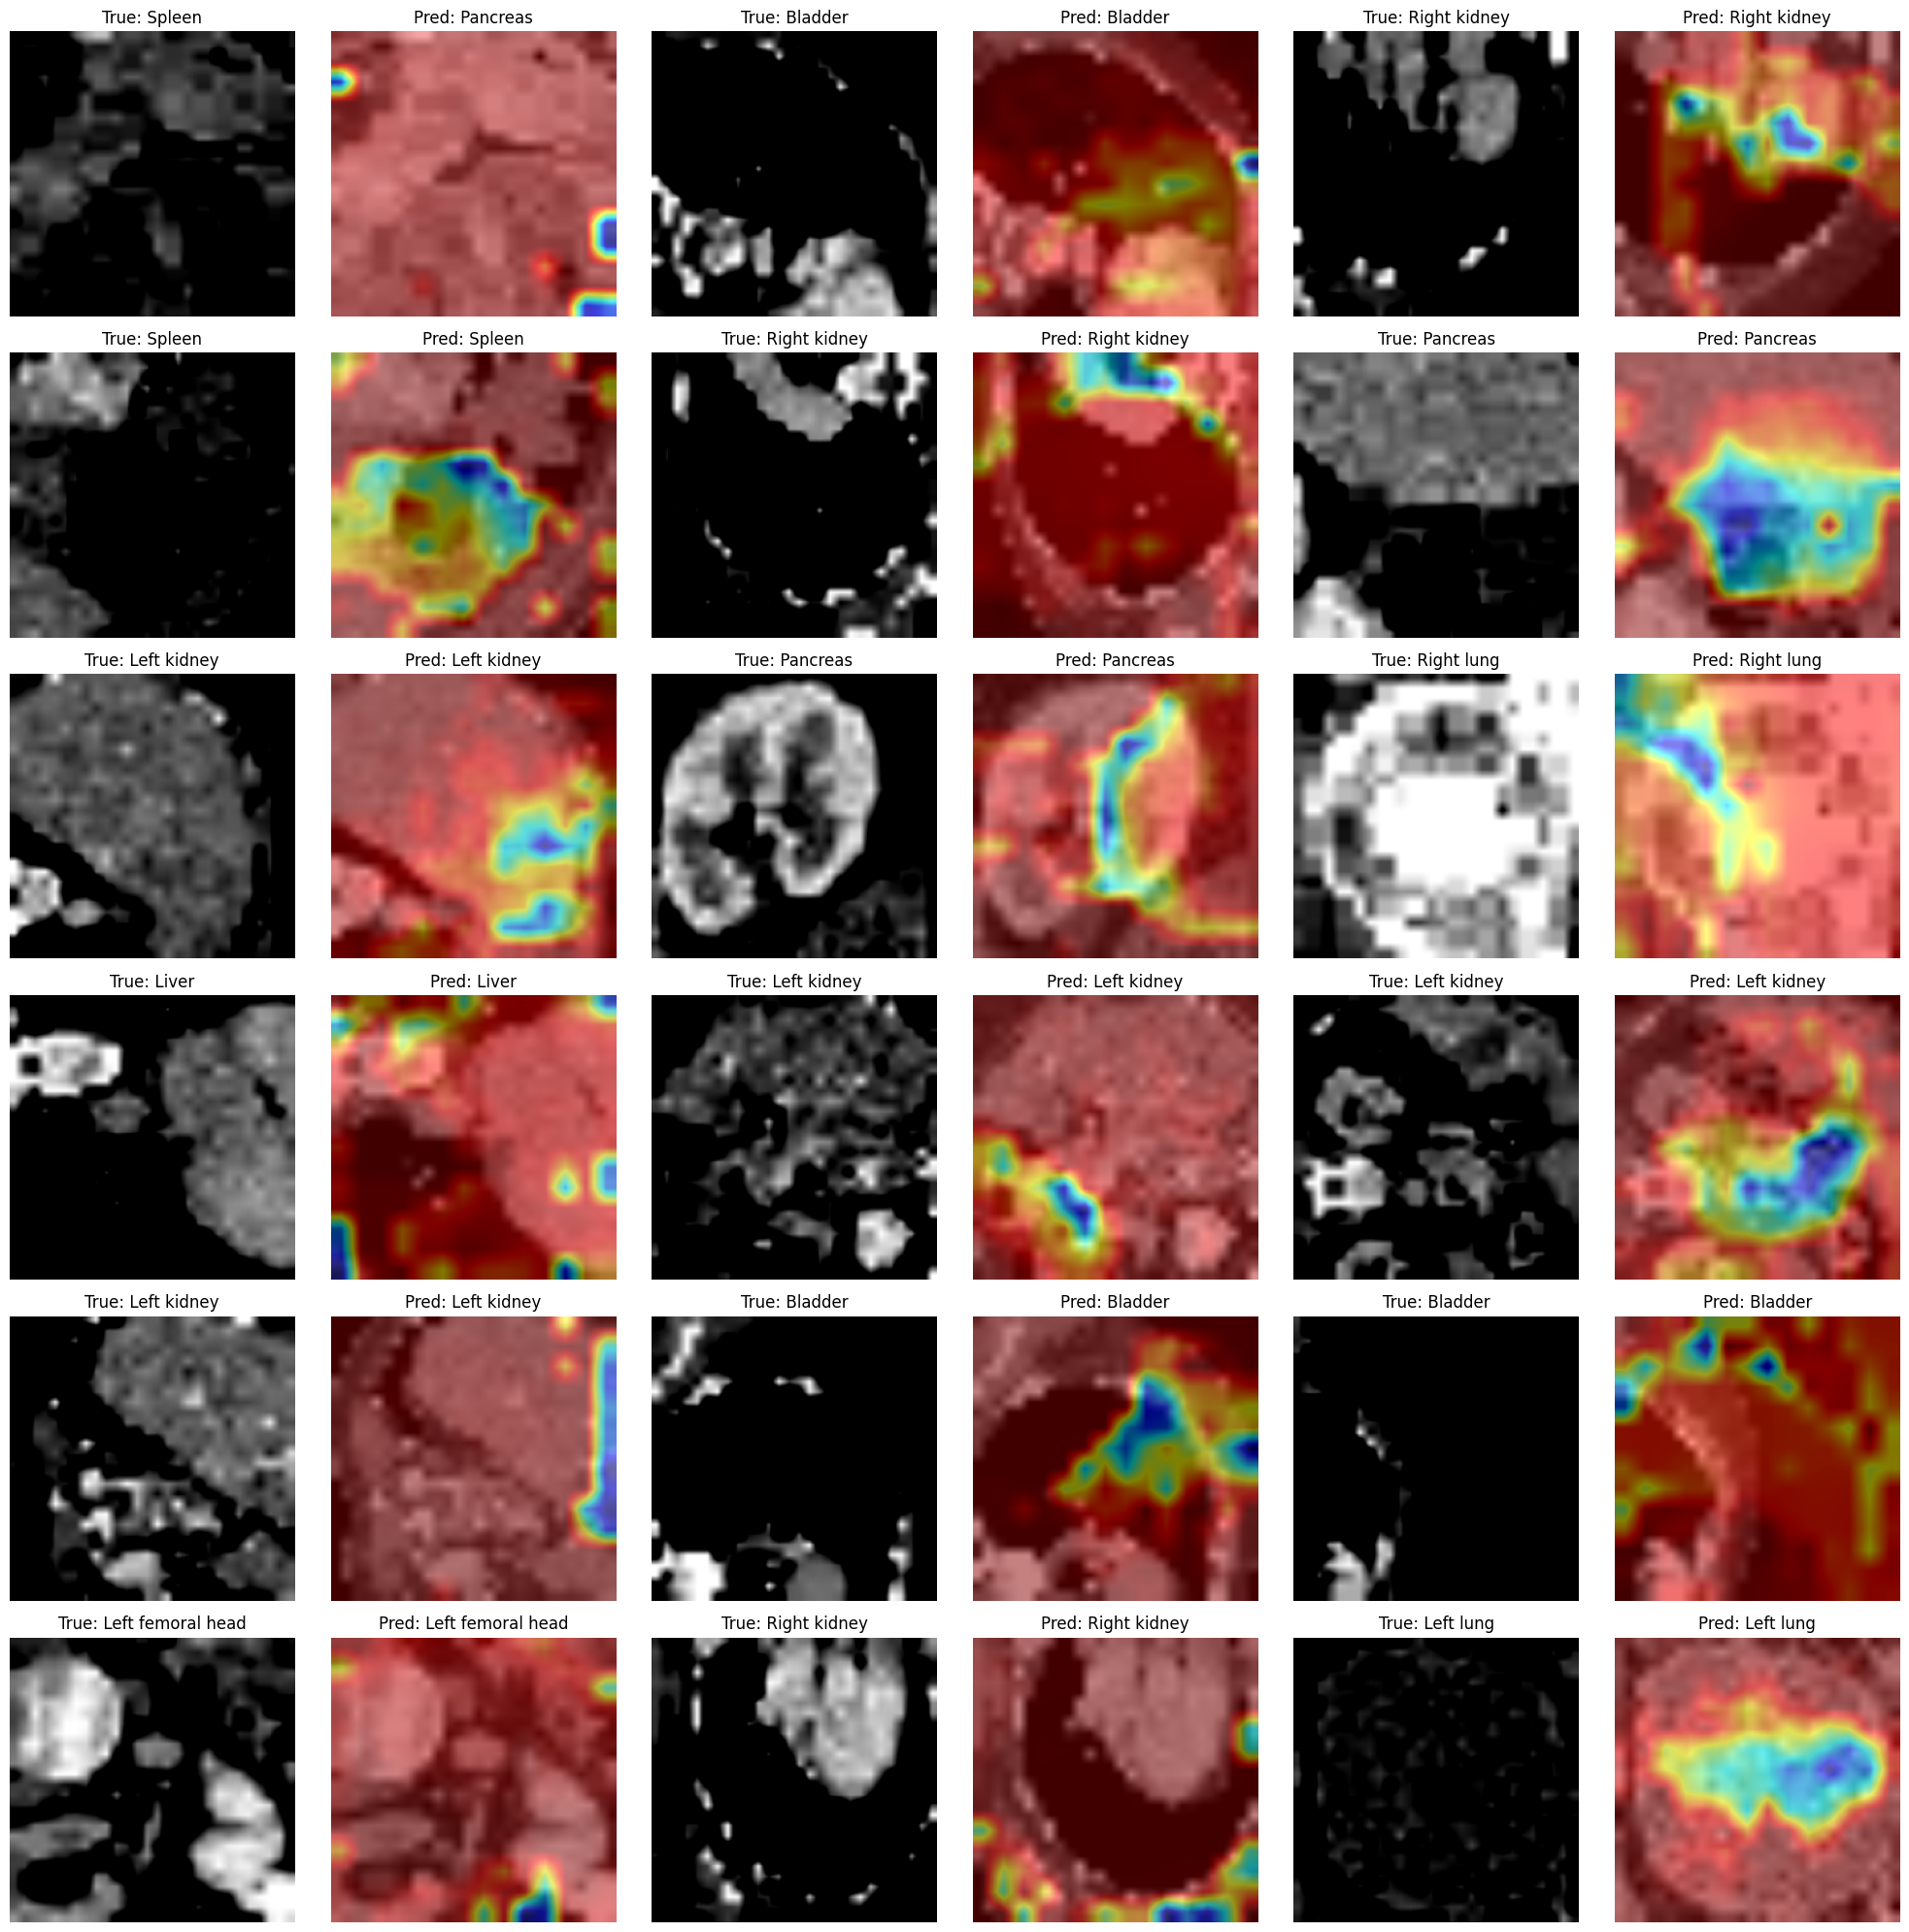

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import OrganAMNIST
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import random

# 类别标签
CLASS_NAMES = [
    "Left lung", "Right lung", "Heart", "Liver", "Spleen", "Pancreas",
    "Left kidney", "Right kidney", "Bladder", "Left femoral head", "Right femoral head"
]

def load_test_data(batch_size=16):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the grayscale image to 3 channels
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    test_dataset = OrganAMNIST(split='test', transform=transform, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader, test_dataset

def load_model(n_classes, model_path='best_model.pth', device='cpu'):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes, output_attentions=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

def visualize_attention(image, attentions, layer_idx=11, head_idx=0):
    # Get the attention map of the specified layer and head
    attention = attentions[layer_idx][0, head_idx]  # Shape: (num_patches, num_patches)

    # Exclude the classification token
    attention = attention[1:, 1:]

    # Average the attention weights across all heads if needed
    attention = attention.mean(dim=0)

    # Reshape the attention map to match the image size
    grid_size = int(np.sqrt(attention.shape[0]))
    attention = attention.view(grid_size, grid_size).detach().cpu().numpy()

    # Resize to the original image size
    attention = cv2.resize(attention, (image.shape[2], image.shape[1]))

    # Normalize the attention map for visualization
    attention = (attention - attention.min()) / (attention.max() - attention.min())

    # Convert to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * attention), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Superimpose the heatmap on the original image
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    superimposed_img = heatmap + image
    superimposed_img = superimposed_img / np.max(superimposed_img)

    return superimposed_img

def evaluate(model, test_loader, device, num_samples=18):
    model.to(device)
    model.eval()

    total, correct = 0, 0
    all_labels, all_preds = [], []
    selected_indices = random.sample(range(len(test_loader.dataset)), num_samples)
    selected_images = []
    selected_true_labels = []
    selected_pred_labels = []
    selected_attentions = []

    current_idx = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()  # Ensure labels are in the correct format

            outputs = model(images)
            attentions = outputs.attentions
            logits = outputs.logits

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            # Check if current batch contains the selected indices
            for i, idx in enumerate(range(current_idx, current_idx + len(images))):
                if idx in selected_indices:
                    selected_images.append(images[i])
                    selected_true_labels.append(labels[i].item())
                    selected_pred_labels.append(predicted[i].item())
                    selected_attentions.append(attentions)
                    if len(selected_images) == num_samples:
                        break

            current_idx += len(images)
            if len(selected_images) == num_samples:
                break

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

    return all_labels, all_preds, selected_images, selected_true_labels, selected_pred_labels, selected_attentions

def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:\n", cm)  # Add this line for debugging
    print("Shape of Confusion Matrix:", cm.shape)  # Add this line for debugging
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(labels, preds, class_names):
    report = classification_report(labels, preds, target_names=class_names, digits=4)
    print("\nClassification Report:\n")
    print(report)

def visualize_images(images, true_labels, pred_labels, attentions, layer_idx=11, head_idx=0):
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    axes = axes.flatten()

    for i in range(18):
        img_with_attention = visualize_attention(images[i], attentions[i], layer_idx, head_idx)
        true_label = CLASS_NAMES[true_labels[i]]
        pred_label = CLASS_NAMES[pred_labels[i]]

        # 原始图像
        axes[2*i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[2*i].set_title(f'True: {true_label}')
        axes[2*i].axis('off')

        # 注意力图像
        axes[2*i+1].imshow(img_with_attention)
        axes[2*i+1].set_title(f'Pred: {pred_label}')
        axes[2*i+1].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader, test_dataset = load_test_data()
    n_classes = len(CLASS_NAMES)  # Use the length of CLASS_NAMES for the number of classes
    model = load_model(n_classes, device=device)
    labels, preds, selected_images, selected_true_labels, selected_pred_labels, selected_attentions = evaluate(model, test_loader, device)
    plot_confusion_matrix(labels, preds, CLASS_NAMES)
    print_classification_report(labels, preds, CLASS_NAMES)
    visualize_images(selected_images, selected_true_labels, selected_pred_labels, selected_attentions)

if __name__ == '__main__':
    main()